In [1]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
  
@tool
def get_web_search(query: str, search_period: str='m') -> str:
    """
    웹 검색을 수행하는 함수.
    """
    wrapper = DuckDuckGoSearchAPIWrapper(
        # region="kr-kr", 
        time=search_period
    )

    print('\n-------- WEB SEARCH --------')
    print(query)
    print(search_period)

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        # source="news",
        results_separator=';\n'
    )

    searched = search.invoke(query)
    
    for i, result in enumerate(searched.split(';\n')):
        print(f'{i+1}. {result}')
    
    return searched

# 도구 바인딩
tools = [get_web_search]

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [4]:
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)


# ReAct 에이전트 생성
agent_executor = create_react_agent(llm, tools, prompt=prompt)

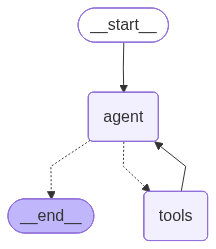

In [5]:
agent_executor

In [13]:
query = "지금 가장 인기 있는 영화를 찾고 인기 이유에 대한 심층 보고서를 작성해줘."

In [7]:
from langchain.schema import HumanMessage

# 에이전트 실행
agent_executor.invoke(
    {"messages": [HumanMessage(content=query)]}
)


-------- WEB SEARCH --------
케이팝데몬헌터스
m
1. snippet: 케이팝데몬헌터스 진우, 데몬헌터스 조이, KPop Demon Hunters 진우, 케이팝 진우 더빙, Netflix 케이팝데몬헌터스 마지막 업데이트 2025-08-18., title: 케이팝데몬헌터스 진ㅇ우 | TikTok, link: https://www.tiktok.com/discover/케이팝데몬헌터스-진ㅇ우
2. snippet: Воспроизвести все. 케이팝데몬헌터스 . 냥냥미용. Плейлист • 14 видео • 26 просмотров., title: 케이팝데몬헌터스 - YouTube, link: https://www.youtube.com/playlist?list=PL6qjaO1Xo42rJZzaPU758o3PGkX0V0dKu
3. snippet: 케이팝데몬헌터스 . 444 пина. · 1 дн., title: 440개의 케이팝데몬헌터스 아이디어 - 2025 | 케이팝, 도시 사진, 일본..., link: https://ru.pinterest.com/jmsbluesky7/케이팝데몬헌터스/
4. snippet: 토픽 OTT뭐볼까 ·. 팔로우. 케이팝데몬헌터스 언어 선택 어떻게 해?, title: 블라인드 | OTT뭐볼까: 케이팝데몬헌터스 언어 선택 어떻게 해?, link: https://www.teamblind.com/kr/post/케이팝데몬헌터스-언어-선택-어떻게-해-571ql0ca


{'messages': [HumanMessage(content='케이팝데몬헌터스에 대해 설명해줘.', additional_kwargs={}, response_metadata={}, id='1fd3f443-0992-4736-966e-9e7f6da8f034'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_web_search', 'arguments': '{"query": "\\ucf00\\uc774\\ud31d\\ub370\\ubaac\\ud5cc\\ud130\\uc2a4"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--14d1f76a-dc0f-414d-b0ce-283aeca79073-0', tool_calls=[{'name': 'get_web_search', 'args': {'query': '케이팝데몬헌터스'}, 'id': '935d2b1a-70de-44d5-ab10-faf2f7e0a2fb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 74, 'total_tokens': 209, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 51}}),
  ToolMessage(content='snippet: 케이팝데몬헌터스 진우, 데몬헌터스 조이, KPop Demon Hunters 진우, 케이팝 진우 더빙, Netflix 케이팝데몬헌터스 마지막 업데이트 2025-08-18., title: 케이팝데몬헌터스 진ㅇ우 | TikTok, link

In [8]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


# 상태 정의
class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]
    plan: Annotated[List[str], "Current plan"]
    past_steps: Annotated[List[Tuple], operator.add]
    response: Annotated[str, "Final response"]

In [9]:
from pydantic import BaseModel, Field
from typing import List


# Plan 모델 정의
class Plan(BaseModel):
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

In [10]:
from langchain_core.prompts import ChatPromptTemplate

# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """주어진 목표에 대해 간단한 단계별 계획을 세워주세요. \
이 계획은 정확한 답을 도출하는 데 필요한 개별적인 작업들로 구성되어야 합니다. \
불필요한 단계는 추가하지 마세요. 마지막 단계의 결과가 최종 답변이어야 합니다. \
각 단계에 필요한 모든 정보가 포함되어 있는지 확인하고, 단계를 건너뛰지 마세요.
답변은 한글로 작성하세요.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0).with_structured_output(Plan)

In [14]:
from langchain.schema import HumanMessage

# Planner 실행
planner.invoke(
    {
        "messages": [
            HumanMessage(content=query)
        ]
    }
)

Plan(steps=['현재 가장 인기 있는 영화를 식별합니다.', '식별된 영화의 인기 요인(예: 비평가 반응, 흥행 성공, 대중적 매력, 마케팅 전략 등)에 대한 정보를 수집합니다.', '수집된 정보를 바탕으로 영화의 인기 이유에 대한 심층 보고서를 작성합니다.'])

In [15]:
from typing import Literal
from pydantic import BaseModel, Field

# 사용자 응답
class Response(BaseModel):
    """Response to user."""
    # 사용자 응답
    response: str = Field(description="The final response to the user.")

# 계획 재수립
class Plan(BaseModel):
    """Action to perform."""
    # 수행할 작업: "Response", "Plan".
    steps: list[str] = Field(description="List of steps to be performed.")


# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """주어진 목표에 대해 간단한 단계별 계획을 세워주세요. \
이 계획은 정확한 답을 도출하는 데 필요한 개별적인 작업들로 구성되어야 합니다. \
불필요한 단계는 추가하지 마세요. 마지막 단계의 결과가 최종 답변이어야 합니다. \
각 단계에 필요한 모든 정보가 포함되어 있는지 확인하고, 단계를 건너뛰지 마세요.

당신의 목표는 다음과 같습니다:
{input}

당신의 원래 계획은 다음과 같습니다:
{plan}

당신이 현재까지 완료한 단계는 다음과 같습니다:
{past_steps}

계획을 적절하게 업데이트하세요. 더 이상 필요한 단계가 없고 사용자에게 답변을 반환할 수 있다면, 그것으로 응답하세요. \
그렇지 않다면, 계획을 다시 작성하세요. 아직 완료되지 않은 단계만 계획에 추가하세요. \
이전에 완료한 단계를 계획에 다시 포함시키지 마세요.

답변은 한글로 작성하세요."""
)


# Replanner 생성
replanner = replanner_prompt | ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0).bind_tools(
    tools=[Response, Plan],
    # tool_choice=Literal["Response", "Plan"]
)

In [16]:
from langchain_core.output_parsers import StrOutputParser


# 사용자 입력을 기반으로 계획을 생성하고 반환
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    # 생성된 계획의 단계 리스트 반환
    return {"plan": plan.steps}


# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)

    # 모델이 도구 호출을 생성했는지 확인
    if output.tool_calls:
        tool_call = output.tool_calls[0]
        tool_name = tool_call['name']
        tool_args = tool_call['args']

        # 도구 이름에 따라 분기
        if tool_name == 'Response':
            return {"response": tool_args.get('response')}
        elif tool_name == 'Plan':
            return {"plan": tool_args.get('steps')}
    
    # 도구 호출이 없는 경우 (일반적인 메시지)
    return {"response": output.content}


# 에이전트의 실행 종료 여부를 결정하는 함수
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "final_report"
    else:
        return "execute"


final_report_prompt = ChatPromptTemplate.from_template(
    """당신에게는 목표와 이전에 완료된 단계들이 주어졌습니다. 당신의 임무는 마크다운 형식으로 최종 보고서를 생성하는 것입니다.
최종 보고서는 전문적인 어조로 작성되어야 합니다.

당신의 목표는 다음과 같습니다:

{input}

이전에 완료된 단계들(질문과 답변 쌍):

{past_steps}

마크다운 형식으로 최종 보고서를 생성하세요. 답변은 한글로 작성하세요."""
)

final_report = (
    final_report_prompt
    | ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
    | StrOutputParser()
)


def generate_final_report(state: PlanExecute):
    past_steps = "\n\n".join(
        [
            f"Question: {past_step[0]}\n\nAnswer: {past_step[1]}\n\n####"
            for past_step in state["past_steps"]
        ]
    )
    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})
    return {"response": response}

In [17]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

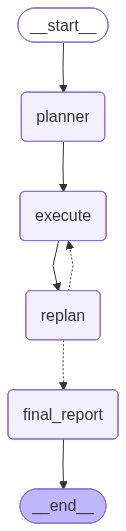

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [20]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [21]:
import uuid

# 에이전트 실행
result = app.invoke(
    {"input": query},
    config={"configurable": {"thread_id": str(uuid.uuid4())}}
)

# 결과 출력
print(result)


-------- WEB SEARCH --------
현재 박스오피스 순위
m

-------- WEB SEARCH --------
영화 평점 사이트
m

-------- WEB SEARCH --------
스트리밍 플랫폼 영화 트렌드
m
1. snippet: 3일 전 — 박찬욱 감독의 신작 한국 영화 '어쩔수가없다'가 개봉 첫날 무려 33만 명이 넘는 관객을 모으며 박스오피스 1위로 오르며 돌풍을 예고했다. 25일 영화진흥위원회 영화관 ..., title: 개봉하자마자 박스오피스 1위…불과 하루 만에 33만 관객 ..., link: https://www.wikitree.co.kr/articles/1083934
2. snippet: 6일 전 — 이 개봉 2주차에 1위로 올라섰습니다. 성적 하락은 거의 없이 일부 스크린 규모가 늘어나면서 순위 상승에 기여했는데 아무래도 호의적인 영화 반응과 더불어 뚜렷한 ..., title: 9월 3주차 국내 박스오피스: 주름 없는 제작비로 쾌거를 ..., link: https://blog.naver.com/hanyu313/224016815806?fromRss=true&trackingCode=rss
3. snippet: 4일 전 — 여기에 주토피아2, 위키드 포 굿, 아바타 불과 재 추가될 예정. 스크랩 공유. 0. 0. 0 분리수거. #영화 · 목록. 이전글. 다음글. 1. 댓글 5. BEST ONOFF., title: 영화 현재까지 올해 글로벌 박스오피스 순위, link: https://m.ruliweb.com/etcs/board/300143/read/72408350
4. snippet: 2시간 전 — 박스오피스 · 1KEEP. 영화 포스터. 어쩔수가없다 · 2KEEP. 영화 포스터. 극장판 체인소 맨: 레제편 · 3KEEP. 영화 포스터. 극장판 귀멸의 칼날: 무한성편 · 4KEEP. 영화 포스터., title: KOBIS 영화관 입장권 통합 전산망, link: https://www.kobis.or.kr/
1. snippe

In [22]:
import pprint

pprint.pprint(result)

{'input': '지금 가장 인기 있는 영화를 찾고 인기 이유에 대한 심층 보고서를 작성해줘.',
 'past_steps': [('현재 가장 인기 있는 영화를 찾기 위해 신뢰할 수 있는 영화 정보 출처(예: 박스오피스 순위, 영화 평점 '
                 '사이트, 스트리밍 플랫폼 트렌드)를 조사합니다.',
                 '조사된 출처를 바탕으로 현재 가장 인기 있는 영화를 선정하겠습니다.\n'
                 '\n'
                 'KOBIS 영화관 입장권 통합 전산망에 따르면 현재 박스오피스 1위는 박찬욱 감독의 신작 '
                 "**'어쩔수가없다'**입니다. 이 영화는 개봉 첫날 33만 명이 넘는 관객을 모으며 돌풍을 일으켰습니다.\n"
                 '\n'
                 "그 외 박스오피스 상위권에는 **'극장판 체인소 맨: 레제편'**과 **'극장판 귀멸의 칼날: "
                 "무한성편'**이 있습니다.\n"
                 '\n'
                 "따라서 현재 가장 인기 있는 영화는 **'어쩔수가없다'**로 선정할 수 있습니다."),
                ('선정된 영화의 인기 요인(예: 흥행 성적, 비평가 및 관객 평가, 사회적 영향, 마케팅 전략, 출연진 및 '
                 '감독)에 대한 심층 정보를 수집합니다.',
                 '선정된 영화가 아직 없습니다. 어떤 영화의 인기 요인에 대한 정보를 수집할까요? 영화 제목을 알려주세요.'),
                ("'어쩔수가없다'의 인기 요인(예: 흥행 성적, 비평가 및 관객 평가, 사회적 영향, 마케팅 전략, 출연진 및 "
                 '감독)에 대한 심층 정보를 수집합니다.',
                 "'어쩔수가없다' 영화의 인기 요인에 대한 심층

In [23]:
print(result["response"])

## 현재 가장 인기 있는 영화 '어쩔수가없다' 심층 보고서

### 1. 서론

본 보고서는 현재 가장 인기 있는 영화를 식별하고, 해당 영화의 인기 요인에 대한 심층 분석을 제공하는 것을 목표로 합니다. 신뢰할 수 있는 영화 정보 출처를 조사한 결과, 박찬욱 감독의 신작 **'어쩔수가없다'**가 현재 대한민국 박스오피스에서 압도적인 1위를 기록하며 가장 높은 인기를 구가하고 있는 것으로 확인되었습니다. 개봉 첫날 33만 명 이상의 관객을 동원하고 예매율 1위를 기록하는 등 개봉 초반부터 폭발적인 반응을 얻고 있는 '어쩔수가없다'의 성공 요인을 다각적으로 분석하고자 합니다.

### 2. '어쩔수가없다'의 인기 요인 분석

'어쩔수가없다'는 다음과 같은 복합적인 요인들이 상호작용하여 대중과 평단의 뜨거운 관심과 호평을 이끌어내고 있습니다.

#### 2.1. 세계적인 거장 박찬욱 감독의 연출력

'어쩔수가없다'는 세계적으로 명성을 떨치고 있는 박찬욱 감독의 신작이라는 점에서 개봉 전부터 국내외 영화계의 지대한 기대를 모았습니다. 감독은 도널드 E. 웨스트레이크의 미국 소설 《액스》를 원작으로 하여 자신만의 독보적인 미학과 연출력을 통해 원작을 재해석했습니다. 평론가들은 "박찬욱 감독의 정교한 연출"을 극찬하며, 그의 섬세하고도 대담한 연출 방식이 영화의 완성도를 극대화하는 데 결정적인 역할을 했다고 평가하고 있습니다. 감독의 이름 자체가 관객들에게 높은 신뢰와 기대감을 부여하는 강력한 흥행 요소로 작용했습니다.

#### 2.2. 압도적인 흥행 성과

영화 '어쩔수가없다'는 개봉과 동시에 압도적인 흥행 성적을 기록하며 대중적 인기를 입증했습니다.
*   개봉 첫날 33만 명 이상의 관객을 동원하며 박스오피스 1위를 차지했습니다.
*   개봉 당일 예매량은 40만 명을 돌파하며 압도적인 예매율 1위를 기록했습니다.
*   개봉 이틀째에도 일일 박스오피스 1위를 유지하며 10만 9천여 명의 관객을 추가 동원했습니다.
*   해외 판매 성과로 순제작비 170억 원